# Classifying Planets

## Introduction

In this classification problem, we embark on a journey where we are presented with a synthetic dataset of planets and moons of our solar system. Our mission is clear: **classify from an image the planet or moon**.

In [1]:
import os
import random
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf

2025-12-06 23:46:02.801194: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set the random seed for reproducibility
seed = 77

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.random.set_seed(seed)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

## Load the data

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "data/raw/.",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256)
)

Found 13901 files belonging to 6 classes.


I0000 00:00:1765061168.988410   74750 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


## Exploring the data

In [4]:
print('Data shape:', dataset.element_spec[0].shape)
print('Data type:', dataset.element_spec[0].dtype)
print('Label shape:', dataset.element_spec[1].shape)
print('Label type:', dataset.element_spec[1].dtype)

labels = dataset.class_names

# Print the labels
print("Labels:")
for i, label in enumerate(labels):
    print(f"{i:4}: {label}")


Data shape: (None, 256, 256, 3)
Data type: <dtype: 'float32'>
Label shape: (None,)
Label type: <dtype: 'int32'>
Labels:
   0: cardboard
   1: glass
   2: metal
   3: paper
   4: plastic
   5: trash


2025-12-06 23:46:10.870850: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


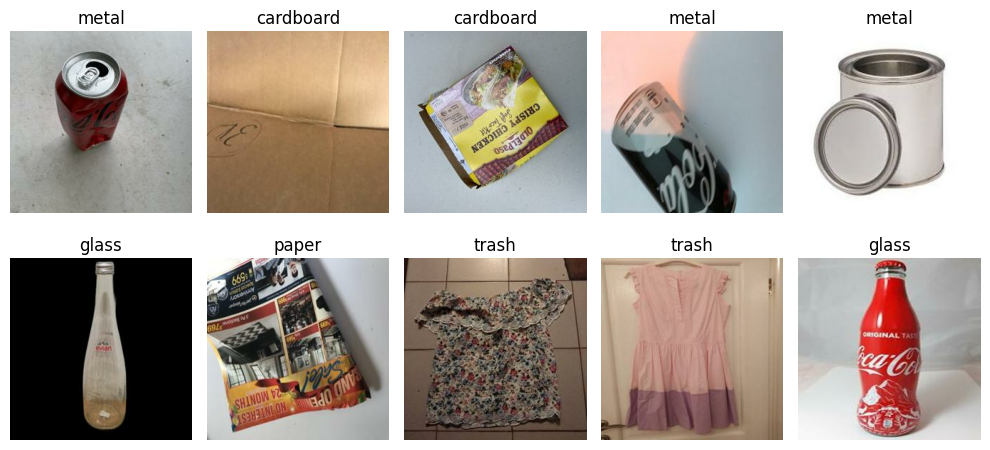

In [5]:
# Plot 10 sample images
plt.figure(figsize=(10, 5), tight_layout=True)
for images, label_idxs in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[label_idxs[i].numpy()])
        plt.axis("off")

## Preparing the data

The following steps are performed to prepare the data:

- Shuffling the data
- Splitting the data into training and validation sets
- Normalizing the data

In [6]:
ds_train, ds_test = tf.keras.utils.image_dataset_from_directory(
    "data/raw/.",
    labels="inferred",
    label_mode="int",
    color_mode="grayscale", #grayscale
    batch_size=32,
    image_size=(32, 32),
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="both",
)

Found 13901 files belonging to 6 classes.
Using 11121 files for training.
Using 2780 files for validation.


2025-12-06 23:46:12.854181: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


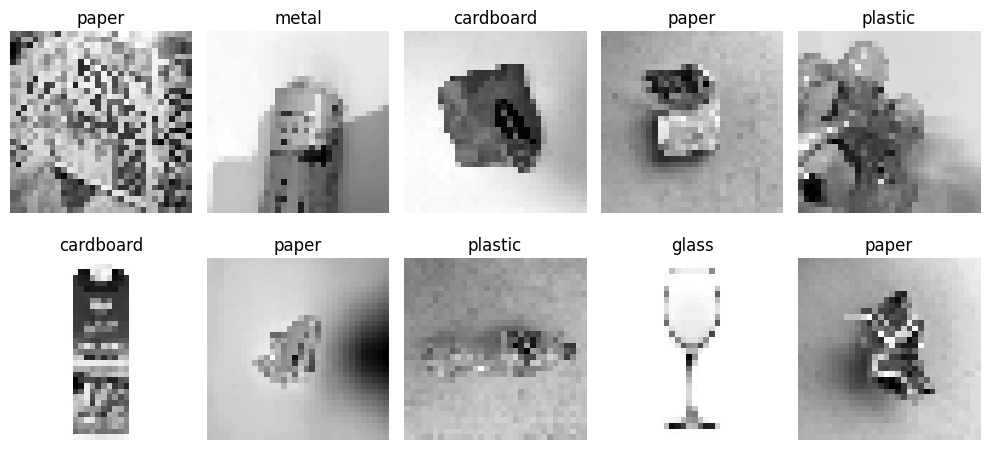

In [7]:
# Plot 10 sample images
plt.figure(figsize=(10, 5), tight_layout=True)
for images, label_idxs in ds_train.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy(), cmap="gray")
        plt.title(labels[label_idxs[i].numpy()])
        plt.axis("off")

In [8]:
# Normalize the data
normalization_layer = tf.keras.layers.Rescaling(
    1.0 / 255
)
ds_train = ds_train.map(lambda x, y: (normalization_layer(x), y))
ds_test = ds_test.map(lambda x, y: (normalization_layer(x), y))


## Training the model

In [9]:
# base_model = tf.keras.applications.MobileNetV2(
#         input_shape=(256, 256, 3),
#         include_top=False,
#         weights='imagenet'
#     )
    
# base_model.trainable = True
    
# model = tf.keras.models.Sequential([
#         base_model,
#         tf.keras.models.layers.GlobalAveragePooling2D(),
#         tf.keras.models.layers.Dropout(0.3),
#         tf.keras.models.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#         tf.keras.models.layers.Dropout(0.3),
#         tf.keras.models.layers.Dense(6, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))
# ])

In [10]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(
                32, (3, 3), activation="mish", input_shape=(32, 32, 1),
            ),
        tf.keras.layers.Conv2D(64, (3, 3), activation="mish"),
        tf.keras.layers.MaxPooling2D((3, 3)),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(64, activation="mish"),
        tf.keras.layers.Dense(6),
    ]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.summary()

/home/cris/mlops/MLOps-project/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       331,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 351,046 (1.34 MB)

 Trainable params: 351,046 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.fit(
    ds_train,
    epochs=2,
    validation_data=ds_test,
)

Epoch 1/2


2025-12-06 23:46:16.236672: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700


348/348 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 1.5799 - sparse_categorical_accuracy: 0.3590 - val_loss: 1.4061 - val_sparse_categorical_accuracy: 0.4504
Epoch 2/2
348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 1.3289 - sparse_categorical_accuracy: 0.4904 - val_loss: 1.2881 - val_sparse_categorical_accuracy: 0.5147


## Model Evaluation

Evaluate the model on the validation set.

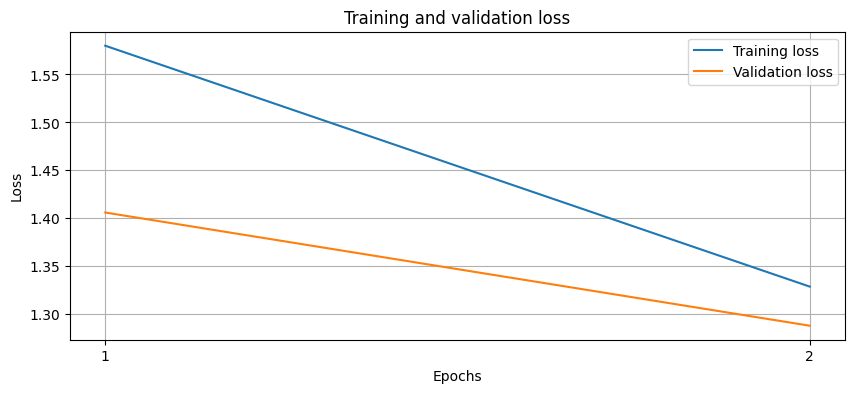

In [12]:
# Plot the training and validation loss
history = model.history.history
epochs = range(1, len(history["loss"]) + 1)

plt.figure(figsize=(10, 4))
plt.plot(epochs, history["loss"], label="Training loss")
plt.plot(epochs, history["val_loss"], label="Validation loss")
plt.xticks(epochs)
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Print validation metrics
val_loss, val_acc = model.evaluate(ds_test)
print(f"Validation loss: {val_loss:.2f}")
print(f"Validation accuracy: {val_acc * 100:.2f}%")

 1/87 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.2680 - sparse_categorical_accuracy: 0.5625

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2881 - sparse_categorical_accuracy: 0.5147
Validation loss: 1.29
Validation accuracy: 51.47%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


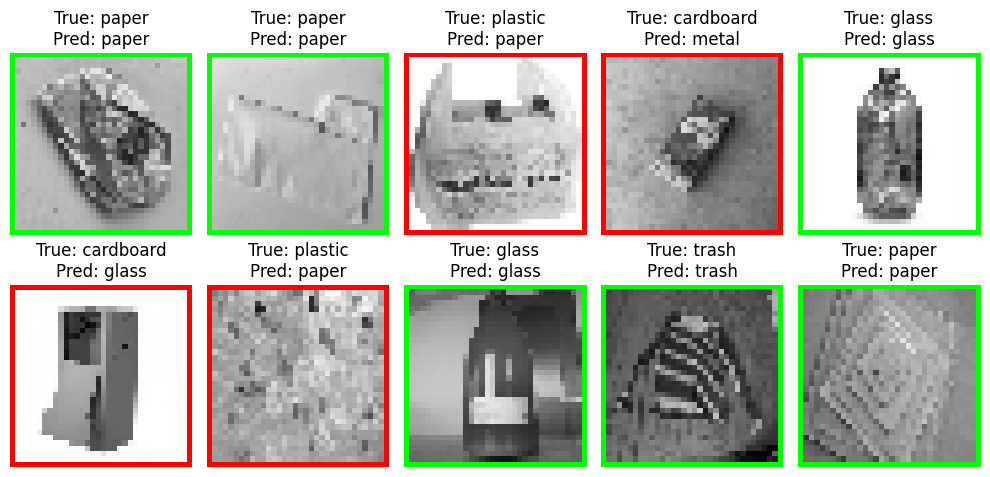

In [14]:
# Take 10 random images from the test set and show the model's predictions
plt.figure(figsize=(10, 5), tight_layout=True)
for images, label_idxs in ds_test.take(1):
    preds = model.predict(images)
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        img = (images[i].numpy() * 255).astype("uint8")
        # Convert image to rgb if grayscale
        if img.shape[-1] == 1:
            img = np.squeeze(img, axis=-1)
            img = np.stack((img,) * 3, axis=-1)
        true_label = labels[label_idxs[i].numpy()]
        pred_label = labels[np.argmax(preds[i])]
        # Add red border if the prediction is wrong else add green border
        img = np.pad(img, pad_width=((1, 1), (1, 1), (0, 0)))
        if true_label != pred_label:
            img[0, :, 0] = 255  # Top border
            img[-1, :, 0] = 255  # Bottom border
            img[:, 0, 0] = 255  # Left border
            img[:, -1, 0] = 255  # Right border
        else:
            img[0, :, 1] = 255
            img[-1, :, 1] = 255
            img[:, 0, 1] = 255
            img[:, -1, 1] = 255

        plt.imshow(img)
        plt.title(f"True: {true_label}\n" f"Pred: {pred_label}")
        plt.axis("off")
plt.show()

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


2025-12-06 23:46:33.314046: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


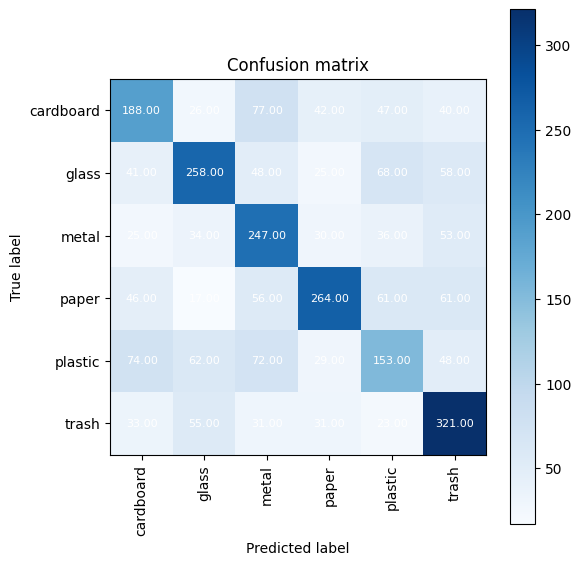

In [15]:
# Show confusion matrix of confidence per class for the test set
plt.figure(figsize=(6, 6), tight_layout=True)
preds = model.predict(ds_test)

conf_matrix = tf.math.confusion_matrix(
    labels=tf.concat([y for _, y in ds_test], axis=0),
    predictions=tf.argmax(preds, axis=1),
    num_classes=len(labels),
)

# Plot the confusion matrix
plt.imshow(conf_matrix, cmap="Blues")

# Plot cell values
for i in range(len(labels)):
    for j in range(len(labels)):
        value = conf_matrix[i, j].numpy()
        if value == 0:
            color = "lightgray"
        elif value > 0.5:
            color = "white"
        else:
            color = "black"
        plt.text(
            j,
            i,
            f"{value:.2f}",
            ha="center",
            va="center",
            color=color,
            fontsize=8,
        )

plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.show()

In [17]:
# Score accuracy, precision and f1-score of model on the test set
test_loss, test_acc = model.evaluate(ds_test)
print(f"Test loss: {test_loss:.2f}")
print(f"Test accuracy: {test_acc * 100:.2f}%")
from sklearn.metrics import precision_score, f1_score
y_true = tf.concat([y for _, y in ds_test], axis=0).numpy()
y_pred = tf.argmax(preds, axis=1).numpy()

# Report scikit-learn classification report
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
print("Classification Report:")
print(report)

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.2881 - sparse_categorical_accuracy: 0.5147
Test loss: 1.29
Test accuracy: 51.47%
Classification Report:
{'cardboard': {'precision': 0.4619164619164619, 'recall': 0.44761904761904764, 'f1-score': 0.4546553808948005, 'support': 420.0}, 'glass': {'precision': 0.5707964601769911, 'recall': 0.5180722891566265, 'f1-score': 0.5431578947368421, 'support': 498.0}, 'metal': {'precision': 0.4651600753295669, 'recall': 0.5811764705882353, 'f1-score': 0.5167364016736402, 'support': 425.0}, 'paper': {'precision': 0.6270783847980997, 'recall': 0.5227722772277228, 'f1-score': 0.5701943844492441, 'support': 505.0}, 'plastic': {'precision': 0.3943298969072165, 'recall': 0.3493150684931507, 'f1-score': 0.3704600484261501, 'support': 438.0}, 'trash': {'precision': 0.5524956970740104, 'recall': 0.6497975708502024, 'f1-score': 0.5972093023255814, 'support': 494.0}, 'accuracy': 0.5147482014388489, 'macro avg': {'precision': 0.5119628293670577, 'recall': 0.511

In [ ]:
from datetime import datetime
from typing import Mapping, Any

from google.cloud import storage  # pip install google-cloud-storage


def push_scores_to_file(
    report: dict,
    bucket_name: str,
    blob_name: str = "scores/eval_scores.csv",
) -> None:
    """
    Append global scores to a CSV stored in a Google Cloud Storage bucket.

    report:
        Dictionary returned by sklearn.metrics.classification_report(output_dict=True)
    bucket_name:
        Name of the GCS bucket
    blob_name:
        Path of the CSV inside the bucket (default: scores/eval_scores.csv)
    """
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_name)

    # Récupérer le CSV existant (s'il existe)
    try:
        csv_text = blob.download_as_text()
    except Exception:
        # Blob n'existe pas encore
        csv_text = ""

    # Ajouter l'en-tête si fichier vide
    if not csv_text:
        csv_text = "timestamp;accuracy;precision;recall;f1_score;support\n"

    # Extraire les scores du report
    now = datetime.now().isoformat(timespec="seconds")
    accuracy = report["accuracy"]
    macro = report["macro avg"]
    precision = macro["precision"]
    recall = macro["recall"]
    f1_score = macro["f1-score"]
    support = macro["support"]

    # Ajouter une nouvelle ligne
    line = f"{now};{accuracy};{precision};{recall};{f1_score};{support}\n"
    csv_text += line

    # Réécrire le CSV dans le bucket
    blob.upload_from_string(csv_text, content_type="text/csv")


In [23]:
from google.cloud.exceptions import NotFound
import pandas as pd

def push_class_scores_to_file(
    report: dict,
    bucket_name: str,
    blob_name: str = "scores/class_scores.csv",
    classes_file: str = "classes.txt",
) -> None:
    """
    Récupère un CSV dans un bucket GCS, ajoute une ligne avec les scores
    par classe, puis réécrit le CSV modifié dans le bucket.

    - report : dict issu de classification_report (sklearn) en format json
    - bucket_name : nom du bucket GCS
    - blob_name : chemin/nom du fichier CSV dans le bucket
    - classes_file : fichier local contenant les classes (séparées par ';')
    """
    now = datetime.now().isoformat(timespec="seconds")
    classes = pd.read_csv(classes_file, sep=";", header=None).values.tolist()[0]
    metrics = ["precision", "recall", "f1-score", "support"]

    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_name)

    # 1) Récupérer le contenu actuel du CSV dans le bucket (s'il existe)
    try:
        csv_text = blob.download_as_text(encoding="utf-8")
        has_content = bool(csv_text.strip())
    except NotFound:
        csv_text = ""
        has_content = False

    # 2) Générer l'en-tête si le fichier est nouveau ou vide
    if not has_content:
        header_parts = ["timestamp"]
        for cls in classes:
            for metric in metrics:
                header_parts.append(f"{cls}_{metric}")
        csv_text = ";".join(header_parts) + "\n"

    # 3) Construire la nouvelle ligne
    row_parts = [now]
    for cls in classes:
        for metric in metrics:
            row_parts.append(str(report[cls][metric]))
    csv_text += ";".join(row_parts) + "\n"

    # 4) Réécrire le CSV dans le bucket
    blob.upload_from_string(csv_text, content_type="text/csv")

In [19]:
push_scores_to_file(
    report,
    bucket_name="mlops-cris-bucket",
)

In [24]:
push_class_scores_to_file(
    report,
    bucket_name="mlops-cris-bucket",
)